<a href="https://colab.research.google.com/github/rahatkader/NN-vs-CNN-on-IoT-Firmware-Image-Classification/blob/main/NNvsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library file import**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset,DataLoader
from torch import optim
from torch import device as dev
from sklearn.metrics import classification_report
import torch.utils.data as tdata
from sklearn import model_selection

In [ ]:
seed = 74
np.random.seed(seed)
torch.manual_seed(seed)

# **Dataset Visualization**

In [ ]:
import glob
import cv2

data = []
label =[]

for file in glob.glob("/content/drive/MyDrive/SCL/Assignment 1/imagery/benignware/*.jpg"):
  im = cv2.imread(file)
  data.append(im)
  label.append('benignware')

for file in glob.glob("/content/drive/MyDrive/SCL/Assignment 1/imagery/gray/*.jpg"):
  data.append(im)
  label.append('gray')

for file in glob.glob("/content/drive/MyDrive/SCL/Assignment 1/imagery/hackware/*.jpg"):
  data.append(im)
  label.append('hackware')

for file in glob.glob("/content/drive/MyDrive/SCL/Assignment 1/imagery/malware/*.jpg"):
  data.append(im)
  label.append('malware')

In [ ]:
dataset = {'images': data, 'label': label}
dataset = pd.DataFrame(dataset)
dataset.head(5)

,images,label
0,"[[[83, 83, 83], [19, 19, 19], [33, 33, 33], [3...",benignware
1,"[[[83, 83, 83], [19, 19, 19], [33, 33, 33], [3...",benignware
2,"[[[83, 83, 83], [19, 19, 19], [33, 33, 33], [3...",benignware
3,"[[[80, 80, 80], [22, 22, 22], [33, 33, 33], [3...",benignware
4,"[[[83, 83, 83], [19, 19, 19], [33, 33, 33], [3...",benignware


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4482 entries, 0 to 4481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4482 non-null   object
 1   label   4482 non-null   object
dtypes: object(2)
memory usage: 70.2+ KB


In [ ]:
dataset.describe()

,images,label
count,4482,4482
unique,2999,4
top,"[[[83, 83, 83], [19, 19, 19], [33, 33, 33], [3...",benignware
freq,1484,2999




---


**Records for each class**

In [ ]:
import seaborn as sns

def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

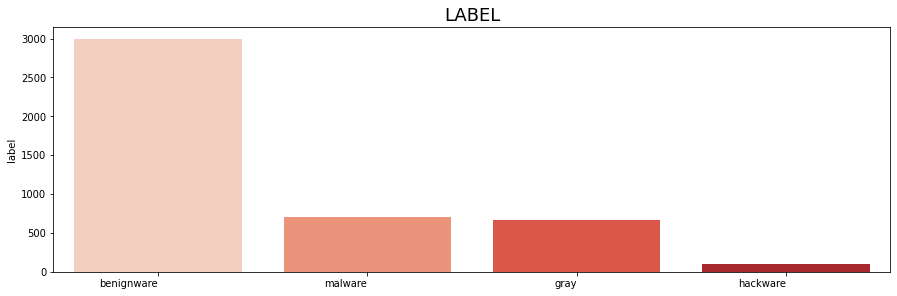

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(dataset, "label", axes, "Reds", 0)
plt.show()



---


**Showing Images For Different Classes**

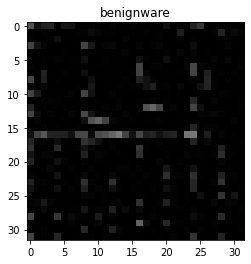

In [ ]:
#benignware
plt.title("benignware")
plt.imshow(data[0])

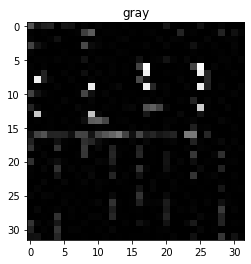

In [ ]:
#gray
plt.title("gray")
plt.imshow(data[3000])

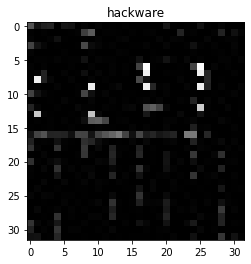

In [ ]:
#hackware
plt.title("hackware")
plt.imshow(data[3700])

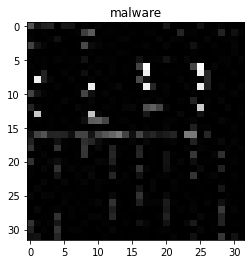

In [ ]:
#malware
plt.title("malware")
plt.imshow(data[4200])

# **Dataset Load & Pre-process**

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

#transforms.functional.rgb_to_grayscale(img: torch.Tensor, num_output_channels: int = 1)


image_datasets = torchvision.datasets.ImageFolder(
                              "/content/drive/MyDrive/SCL/Assignment 1/imagery", 
                              transform = image_transforms)

devset_indices = np.arange(len(image_datasets))
devset_labels = image_datasets.targets

train_indices, test_indices, train_labels,  test_labels = model_selection.train_test_split(
                                                  devset_indices, devset_labels, 
                                                  test_size=0.8, stratify=devset_labels, 
                                                  shuffle=True)

test_image_datasets = tdata.Subset(image_datasets, test_indices)
train_image_datasets = tdata.Subset(image_datasets, test_indices)

test_loader = DataLoader(test_image_datasets, batch_size = 20)
train_loader = DataLoader(train_image_datasets, batch_size = 20)

# **Neural Network**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.fc6 = nn.Linear(100, 100)
        self.fc7 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return F.log_softmax(x, dim=1)

model = NeuralNetwork()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 20

In [ ]:
iteration_loss =[]

for epoch in range(EPOCHS):
    for data in train_loader:
        X, y = data
        model.zero_grad()
        output = model(X.view(-1, 32*32*3))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        
    iteration_loss.append(loss.item())
    print('epoch: {}. Loss: {}'.format(epoch, loss.item()))

epoch: 0. Loss: 0.10049548745155334
epoch: 1. Loss: 0.0017835100879892707
epoch: 2. Loss: 0.0009925273479893804
epoch: 3. Loss: 0.0005245251231826842
epoch: 4. Loss: 0.0004884973168373108
epoch: 5. Loss: 1.2040004548907746e-05
epoch: 6. Loss: 5.364415187614213e-07
epoch: 7. Loss: 5.9604641222676946e-08
epoch: 8. Loss: 0.0021806980948895216
epoch: 9. Loss: 7.316818664548919e-05
epoch: 10. Loss: 2.1139238015166484e-05
epoch: 11. Loss: 0.008981786668300629
epoch: 12. Loss: 2.731806853262242e-05
epoch: 13. Loss: 9.688304271548986e-05
epoch: 14. Loss: 3.298112687843968e-06
epoch: 15. Loss: 1.8278724382980727e-06
epoch: 16. Loss: 1.3907748552810517e-07
epoch: 17. Loss: 3.973642748178463e-08
epoch: 18. Loss: 0.0
epoch: 19. Loss: 0.0


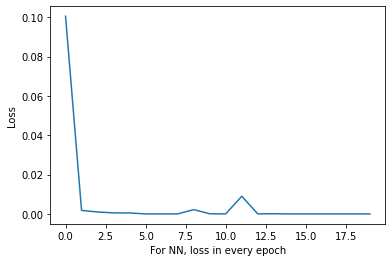

In [ ]:
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('For NN, loss in every epoch')
plt.show()

In [ ]:
# Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        data_input, target = data
        output = model(data_input.view(-1, 32*32*3))
        for idx, i in enumerate(output):
            if torch.argmax(i) == target[idx]:
                correct += 1
            total += 1

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 100 %


In [ ]:
# train Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        data_input, target = data
        output = model(data_input.view(-1, 32*32*3))
        for idx, i in enumerate(output):
            if torch.argmax(i) == target[idx]:
                correct += 1
            total += 1

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 100 %


# **Convolutional Neural Networks**

In [ ]:
class CNeuralNetwork(nn.Module):
    def __init__(self):
        super(CNeuralNetwork, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=3, out_channels=256,kernel_size=3, stride=1, padding=1)

        self.cnn_layer_2 = nn.Conv2d(in_channels=256, out_channels=128,kernel_size=3, stride=1, padding=1)
        self.cnn_layer_3 = nn.Conv2d(in_channels=128, out_channels=64,kernel_size=3, stride=1, padding=1)

        self.cnn_layer_4 = nn.Conv2d(in_channels=64, out_channels=32,kernel_size=3, stride=1, padding=1)
        
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2)
        
        self.linear_layer_1 = nn.Linear(128, 512)
        self.linear_layer_2 = nn.Linear(512, 128) 
        self.linear_layer_3 = nn.Linear(128, 64) 
        self.linear_layer_4 = nn.Linear(64, 32)
        self.linear_layer_5 = nn.Linear(32, 4)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(.2)
        
    def forward(self, x):

        # Input layer
        x = self.cnn_layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)

        # Hidden layer 1
        x = self.cnn_layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)

        # Hidden layer 2
        x = self.cnn_layer_3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)

        # Hidden layer 3
        x = self.cnn_layer_4(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.shape)

        x = self.flatten(x)
        #print(x.shape)

        x = self.linear_layer_1(x)
        #x = self.dropout(x)
        x = self.relu(x)
        #print(x.shape)
        
        x = self.linear_layer_2(x)
        #x = self.dropout(x)
        x = self.relu(x)
        #print(x.shape)

        x = self.linear_layer_3(x)
        #x = self.dropout(x)
        x = self.relu(x)
        #print(x.shape)

        x = self.linear_layer_4(x)
        #x = self.dropout(x)
        x = self.relu(x)
        #print(x.shape)
        
        x = self.linear_layer_5(x)
        return F.log_softmax(x, dim=1)

model2 = CNeuralNetwork()

In [ ]:
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
EPOCHS2 = 20

In [ ]:
iteration_loss2 =[]

for epoch in range(EPOCHS2):
    for data in train_loader:
        X, y = data
        model2.zero_grad()
        output = model2(X)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer2.step()
        
    iteration_loss2.append(loss.item())
    print('epoch: {}. Loss: {}'.format(epoch, loss.item()))

epoch: 0. Loss: 0.9184880256652832
epoch: 1. Loss: 0.8937839865684509
epoch: 2. Loss: 0.91597580909729
epoch: 3. Loss: 0.8953423500061035
epoch: 4. Loss: 0.8616025447845459
epoch: 5. Loss: 0.7751073241233826
epoch: 6. Loss: 0.7651047110557556
epoch: 7. Loss: 0.7498164176940918
epoch: 8. Loss: 0.7108756899833679
epoch: 9. Loss: 0.6817869544029236
epoch: 10. Loss: 0.6718637943267822
epoch: 11. Loss: 0.44497230648994446
epoch: 12. Loss: 0.44465371966362
epoch: 13. Loss: 0.2989614009857178
epoch: 14. Loss: 0.1945093721151352
epoch: 15. Loss: 0.01646517775952816
epoch: 16. Loss: 0.4358700215816498
epoch: 17. Loss: 0.08689696341753006
epoch: 18. Loss: 0.0080869160592556
epoch: 19. Loss: 0.001103211659938097


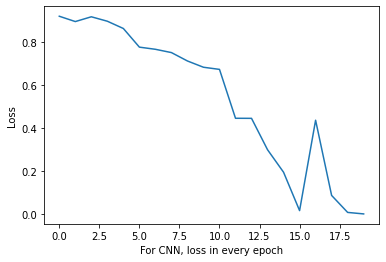

In [ ]:
plt.plot(iteration_loss2)
plt.ylabel('Loss')
plt.xlabel('For CNN, loss in every epoch')
plt.show()

In [ ]:
# Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        data_input, target = data
        output = model2(data_input)
        for idx, i in enumerate(output):
            if torch.argmax(i) == target[idx]:
                correct += 1
            total += 1

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 98 %


In [ ]:
# train Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        data_input, target = data
        output = model2(data_input)
        for idx, i in enumerate(output):
            if torch.argmax(i) == target[idx]:
                correct += 1
            total += 1

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 98 %
